In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import math
import numpy.linalg as la
scaling=False

In [2]:
#Fashion mnist
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import model_selection
from sklearn import linear_model, ensemble, tree, neighbors, svm
from mnist.loader import MNIST

In [3]:
print("Fetching Fashion-Mnist")
print("=========================")
mndata = MNIST('../fashion-mnist/data/fashion') #added path extension for new file structure
train, train_labels = mndata.load_training()
test, test_labels = mndata.load_testing()
data = np.array(np.vstack([train, test]), dtype=np.float64) / 255.0
target = np.hstack([train_labels, test_labels])
classes = [
    'T-shirt/top',
    'Trouser', 
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot']
print("Fashion-Mnist loaded")
print ("=========================")

Fetching Fashion-Mnist
Fashion-Mnist loaded


## A breif overview of the Kabsch Algorithm 

4 Rigid motion computation - summary
Let us summarize the steps to computing the optimal translation $\mathbf{t}$ and rotation $R$ that minimize
$$
\sum_{i=1}^n w_i\left\|\left(R \mathbf{p}_i+\mathbf{t}\right)-\mathbf{q}_i\right\|^2
$$
1. Compute the weighted centroids of both point sets:
$$
\overline{\mathbf{p}}=\frac{\sum_{i=1}^n w_i \mathbf{p}_i}{\sum_{i=1}^n w_i}, \quad \overline{\mathbf{q}}=\frac{\sum_{i=1}^n w_i \mathbf{q}_i}{\sum_{i=1}^n w_i} .
$$
2. Compute the centered vectors
$$
\mathbf{x}_i:=\mathbf{p}_i-\overline{\mathbf{p}}, \quad \mathbf{y}_i:=\mathbf{q}_i-\overline{\mathbf{q}}, \quad i=1,2, \ldots, n .
$$
3. Compute the $d \times d$ covariance matrix
$$
S=X W Y^{\top},
$$
where $X$ and $Y$ are the $d \times n$ matrices that have $\mathbf{x}_i$ and $\mathbf{y}_i$ as their columns, respectively, and $W=\operatorname{diag}\left(w_1, w_2, \ldots, w_n\right)$.
4. Compute the singular value decomposition $S=U \Sigma V^{\top}$. The rotation we are looking for is then
$$
R=V\left(\begin{array}{cccc}
1 & & & \\
& 1 & & \\
& & \ddots & \\
& & 1 & \\
& & & \operatorname{det}\left(V U^{\top}\right)
\end{array}\right) U^{\top} .
$$
5. Compute the optimal translation as
$$
\mathbf{t}=\overline{\mathbf{q}}-R \overline{\mathbf{p}}
$$

In [4]:
def Kabsch_3D(A, B, scale):
    #setup and saftey check
    assert np.shape(A)==np.shape(B)
    N = A.shape[0];  # total points
    
    #_______________________________________________________________________________________
    #               Compute the weighted centroids of both point sets:
    #_______________________________________________________________________________________
    
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    
    #_______________________________________________________________________________________
    #                       Compute the centered vectors
    #_______________________________________________________________________________________
    
    X = A - np.tile(centroid_A, (N, 1))
    Y = B - np.tile(centroid_B, (N, 1))
    
    #_______________________________________________________________________________________
    #                      Compute the  𝑑×𝑑  covariance matrix
    #_______________________________________________________________________________________
    
    
    H=X@Y.T
    """  if scale:
        H = np.transpose(BB) * AA / N
    else:
        H = np.transpose(BB) * AA"""

    #_______________________________________________________________________________________
    #                     Compute the singular value decomposition  𝑆=𝑈Σ𝑉⊤ .  
    #_______________________________________________________________________________________
        
    U, S, Vt = la.svd(H)

    R = Vt.T * U.T

    # special reflection case
    if la.det(R) < 0:
        print ("Reflection")
        Vt[2, :] *= -1
        R = Vt.T * U.T

    if scale:
        varA = np.var(A, axis=0).sum()
        c = 1 / (1 / varA * np.sum(S))  # scale factor
        t = -R * (centroid_B.T * c) + centroid_A.T
    else:
        print(R.shape,centroid_B.T.shape,centroid_A.T.shape)
        c = 1
        t = centroid_B-R@centroid_A #-R @ centroid_B.T + centroid_A.T 

    return c, R, t

In [5]:
def calc_rmse(A,B,r,t):
    print(r.shape)
    print(t.shape)
    print(l.shape)
    print(i.shape)
    # Find the error
    B2 = (r @ B.T) + t#np.tile(t, (1, n))
    B2 = B2.T
    err = A - B2
    err = np.multiply(err, err)
    err = np.sum(err)
    rmse = sqrt(err / n);
    return rmse

In [234]:

# Test
A = np.matrix([[10.0, 10.0, 10.0],
               [20.0, 10.0, 10.0],
               [20.0, 10.0, 15.0]])

B = np.matrix([[18.8106, 17.6222, 12.8169],
               [28.6581, 19.3591, 12.8173],
               [28.9554, 17.6748, 17.5159]])

n = B.shape[0]

Ttarg = np.matrix([[0.9848, 0.1737,0.0000,-11.5859],
                   [-0.1632,0.9254,0.3420, -7.621],
                   [0.0594,-0.3369,0.9400,2.7755],
                   [0.0000, 0.0000,0.0000,1.0000]])

Tstarg = np.matrix([[0.9848, 0.1737,0.0000,-11.5865],
                   [-0.1632,0.9254,0.3420, -7.621],
                   [0.0594,-0.3369,0.9400,2.7752],
                   [0.0000, 0.0000,0.0000,1.0000]])

# recover the transformation
s, approx_Rotation, approx_translation = Kabsch_3D(A, B, scaling)
#find rmse
rmse=calc_rmse(A,B,approx_Rotation,approx_translation)
#convert to 4x4 transform
match_target = np.zeros((4,4))
match_target[:3,:3] = approx_Rotation
#Manually assigning column of homogenous 
match_target[0,3] = approx_translation[0]
match_target[1,3] = approx_translation[1]
match_target[2,3] = approx_translation[2]
match_target[3,3] = 1

print(approx_translation)
print ("Points A")
print (A)
print ("")
print ("Points B")
print( B)
print ("")
print ("Rotation")
print (approx_Rotation)
print ("")
print ("Translation")
print (approx_translation)
print ("")
print ("Scale")
print (s)
print ("")
print ("Homogeneous Transform")
print( match_target)
print ("")
if scaling:
    print ("Total Diff to SA matrix")
    print (np.sum(match_target - Tstarg))
    print ("")
else:
    print ("Total Diff to SA matrix")
    print (np.sum(match_target - Ttarg))
    print ("")

print ("RMSE:", rmse)
print ("If RMSE is near zero, the function is correct!")

(3, 3) (3, 1) (3, 1)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 3)

In [6]:
def rotate(theta,image):
    
    theta=math.radians(theta)                               #converting degrees to radians
    cosine=math.cos(theta)
    sine=math.sin(theta)
                                 
    
    # Compute augmented image dimensions
    new_height  = round(abs(image.shape[0]*cosine)+abs(image.shape[1]*sine))+1
    new_width  = round(abs(image.shape[1]*cosine)+abs(image.shape[0]*sine))+1

    #init temp matrix to be populated with individually rotated elements
    output=np.zeros((new_height,new_width))
    # Identify point of rotation in original image
    original_centre_height   = round(((image.shape[0]+1)/2)-1)    #with respect to the original image
    original_centre_width    = round(((image.shape[1]+1)/2)-1)    #with respect to the original image

    # Find the centre of the new image that will be obtained
    new_centre_height= round(((new_height+1)/2)-1)        #with respect to the new image
    new_centre_width= round(((new_width+1)/2)-1)          #with respect to the new image
    
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            #co-ordinates of pixel with respect to the centre of original image
            y=image.shape[0]-1-i-original_centre_height                   
            x=image.shape[1]-1-j-original_centre_width 

            #Applying shear Transformation                     
            new_y,new_x=shear(theta,x,y)
            #Adjust coordinates to be relative to the new center after rotation
            new_y=new_centre_height-new_y
            new_x=new_centre_width-new_x

            output[new_y,new_x]=image[i,j]                          #writing the pixels to the new destination in the output image
    
    #trim output: 
    # iterate through matrix, if there exists an element less than tau round it down to 0
    tau=.1
    for j in range(output.shape[0]):
        for k in range(output.shape[0]):
            if output[j][k]<tau:
                output[j][k]=np.rint(output[j][k])
                
    # identify indices of zero rows and columns and delete them from the final matrix( could be done with less lines )
    
    idx = np.argwhere(np.all(output[..., :] == 0, axis=0))
    o2 = np.delete(output, idx, axis=0)
    idy = np.argwhere(np.all(output[..., :] == 0, axis=1))
    o3= np.delete(o2, idy, axis=1)
   
    return o3           
    
    #return output

In [10]:
# A shear is used here to avoid issues with anti aliasing, method described by 
#vhttps://www.ocf.berkeley.edu/~fricke/projects/israel/paeth/rotation_by_shearing.html
def shear(angle,x,y):
    '''
    |1  -tan(𝜃/2) |  |1        0|  |1  -tan(𝜃/2) | 
    |0      1     |  |sin(𝜃)   1|  |0      1     |
    '''
    
    tangent=math.tan(angle/2)
    new_x=round(x-y*tangent)
    new_y=y
    
    new_y=round(new_x*math.sin(angle)+new_y)      #since there is no change in new_x according to the shear matrix
    new_x=round(new_x-new_y*tangent)              #since there is no change in new_y according to the shear matrix
    
    return new_y,new_x

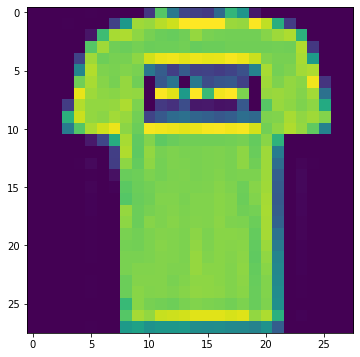

(29, 29)


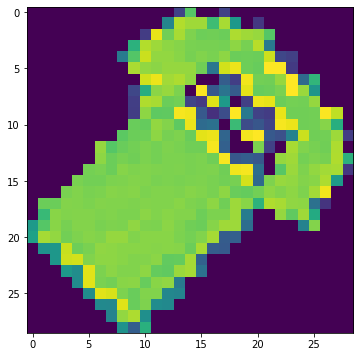

(29, 29)
(28, 28)


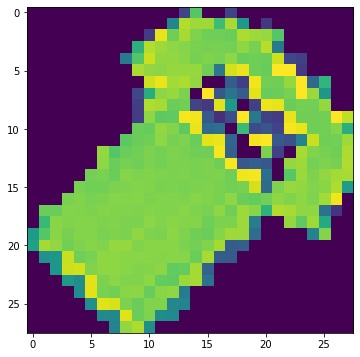

In [12]:
#testing rotations on sample image 

l=np.reshape(data[1],(28,28))
fig = plt.figure( figsize=(8, 6))
plt.imshow(l, cmap='viridis')
plt.show()

#fails for 5,6 degrees for some reason, debugging needed 
i=rotate(45,l)
print(i.shape)
fig = plt.figure( figsize=(8, 6))
plt.imshow(i, cmap='viridis')
plt.show()
"""Since the rotations are not perfect we end up with some small descrepancies in dimensionality.
This will have to be remedied with some concessions so we will be trimming off one row and column from the dimension max."""
print(np.shape(i))
i=np.delete(i,28,1)
i=np.delete(i,28,0)
print(i.shape)

fig = plt.figure( figsize=(8, 6))
plt.imshow(i, cmap='viridis')
plt.show()

Reflection
(28, 28) (28,) (28,)
(28, 28)
(28,)
(28, 28)
(28, 28)
Plot of Homogenous coordinates


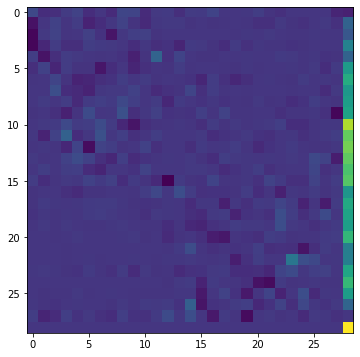

RMSE: 2.348858285415269
If RMSE is near zero, the function is correct!


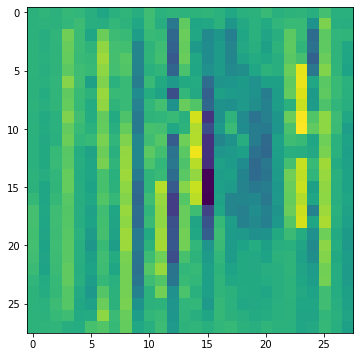

In [238]:
n=np.shape(i)[0]
# recover the transformation
s, approx_Rotation, approx_translation = Kabsch_3D(l, i, scaling)

#find rmse
rmse=calc_rmse(l,i,approx_Rotation,approx_translation)

#convert to 4x4 transform
match_target = np.zeros((n+1,n+1))
match_target[:n,:n] = approx_Rotation
#Manually assigning column of homogenous 
for j in range(n-1):
    match_target[j][n] = approx_translation[j]
match_target[n][n]=1
print("Plot of Homogenous coordinates")
fig = plt.figure( figsize=(8, 6))
plt.imshow(match_target, cmap='viridis')
plt.show()



print ("RMSE:", rmse)
print ("If RMSE is near zero, the function is correct!")
#Manually applying tranosformations since there are issues with the homogenous matrix for some reason. 

test_correction=i@approx_Rotation
test_correction=test_correction*approx_translation



fig = plt.figure( figsize=(8, 6))
plt.imshow(test_correction, cmap='viridis')
plt.show()

Algorithm Kabsch-Umeyama

Compute $d \times d$ matrix $M=Q P^T$.

Compute SVD of $M$, i.e., identify $d \times d$ matrices $V, S, W$,

so that $M=V S W^T$ in the SVD sense.

Set $s_1=\ldots=s_{d-1}=1$.

If $\operatorname{det}(V W)>0$, then set $s_d=1$, else set $s_d=-1$.

Set $\tilde{S}=\operatorname{diag}\left\{s_1, \ldots, s_d\right\}$.

Return $d \times d$ rotation matrix $U=W \tilde{S} V^T$.

In [13]:
def kabsch_2(Q,P):
    M=Q@P.T
    V,S,Wt=la.svd(M)
    S=np.ones(Q.shape[0])
    
    if la.det(V@Wt.T)>0:
        S[Q.shape[0]]=-1
    S_=np.diag(S)
    return Wt.T@S_@V.T

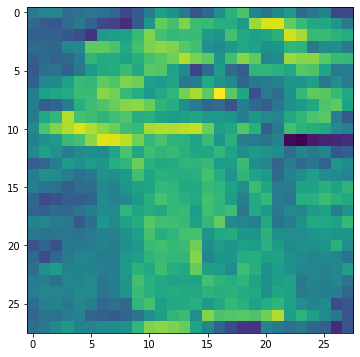

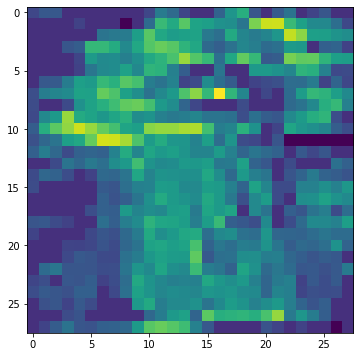

In [14]:
#Kabsch 2 testing 

r_guess=kabsch_2(l,i)


dirty_correction=(i.T@r_guess).T
fig = plt.figure( figsize=(8, 6))
plt.imshow(dirty_correction, cmap='viridis')
plt.show()
cleaned_correction=dirty_correction

# iterate through matrix, if there exists an element less than tau round it down to 0
tau=.1
for j in range(dirty_correction.shape[0]):
    for k in range(dirty_correction.shape[0]):
        if dirty_correction[j][k]<tau:
            cleaned_correction[j][k]=np.rint(dirty_correction[j][k])/4
                         
fig = plt.figure( figsize=(8, 6))
plt.imshow(cleaned_correction, cmap='viridis')
plt.show()

[[-0.14574025  0.00595382  0.03460043 -0.16252395  0.27433302 -0.12268455
   0.10598279  0.12032806 -0.24691551  0.02166528 -0.08094311  0.10541029
   0.13182082 -0.27345559 -0.03790138 -0.23418354  0.3358952  -0.28719897
  -0.24057737  0.32447447  0.03372242  0.23708616  0.10915892 -0.07890117
   0.26033728  0.03401542 -0.32269767  0.02311855]
 [-0.13256519 -0.04703872 -0.01800038  0.0333615   0.21230131 -0.35940722
  -0.15318174  0.33342112 -0.16684886 -0.1817739  -0.05309761  0.02511393
   0.11484081  0.08715111  0.1956366  -0.15692224 -0.19414413  0.41671947
  -0.01808026  0.06506606  0.06733314  0.06444041 -0.29962354 -0.23955468
   0.20365577  0.00735624  0.32047456  0.07678856]
 [ 0.36325285  0.40963079 -0.06585276 -0.04967284  0.03005596 -0.04608636
  -0.09748417  0.0964642  -0.18092722 -0.10419009 -0.17012948  0.23716579
   0.27935162  0.20932197  0.05871815  0.10020133  0.11247058 -0.03109206
  -0.0550277  -0.26712269  0.15079533  0.24086593  0.33629129 -0.03418271
  -0.13633

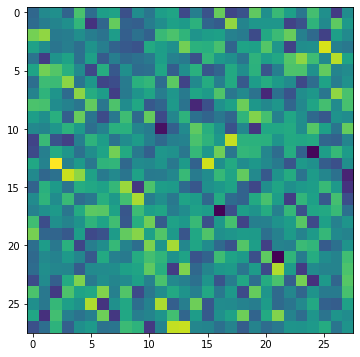

In [16]:
print(r_guess)
print(r_guess.shape)
fig = plt.figure( figsize=(8, 6))
plt.imshow(r_guess, cmap='viridis')
plt.show()